<a href="https://colab.research.google.com/github/Suhith97/cs480student/blob/main/CS480_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

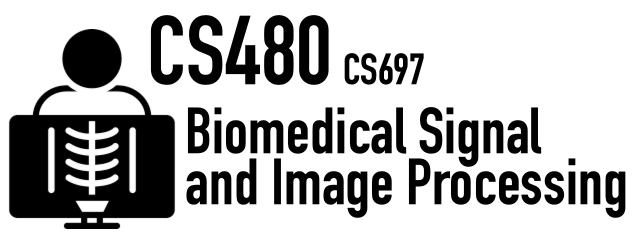
#Assignment 5

In [ ]:
# In this assignment, we will visualize and explore a CT scan!

In [ ]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# we are using pydicom, so lets install it!
!pip install pydicom

     |████████████████████████████████| 1.9MB 8.5MB/s 


**Task 1**: Download and visualize data with SliceDrop! [20 Points]

In [4]:
# Please download https://cs480.org/data/ct.zip and extract it on your computer!
# This is a CT scan of an arm in DICOM format.

In [5]:
# 1) Let's explore the data without loading it.
# TODO: Without loading the data, how many slices are there?

In [7]:
# TODO: YOUR_ANSWER


220 Slices

In [8]:
# 2) Let's visualize the data with SliceDrop! 
# Go to https://slicedrop.com and drag'n'drop all .dcm files into the browser.
# Please use the 2D sliders to show axial, sagittal, and coronal slices in 3D.

In [9]:
# TODO Please post a screenshot of SliceDrop's 3D View in the text box below by 
# using the Upload image button after double-click.

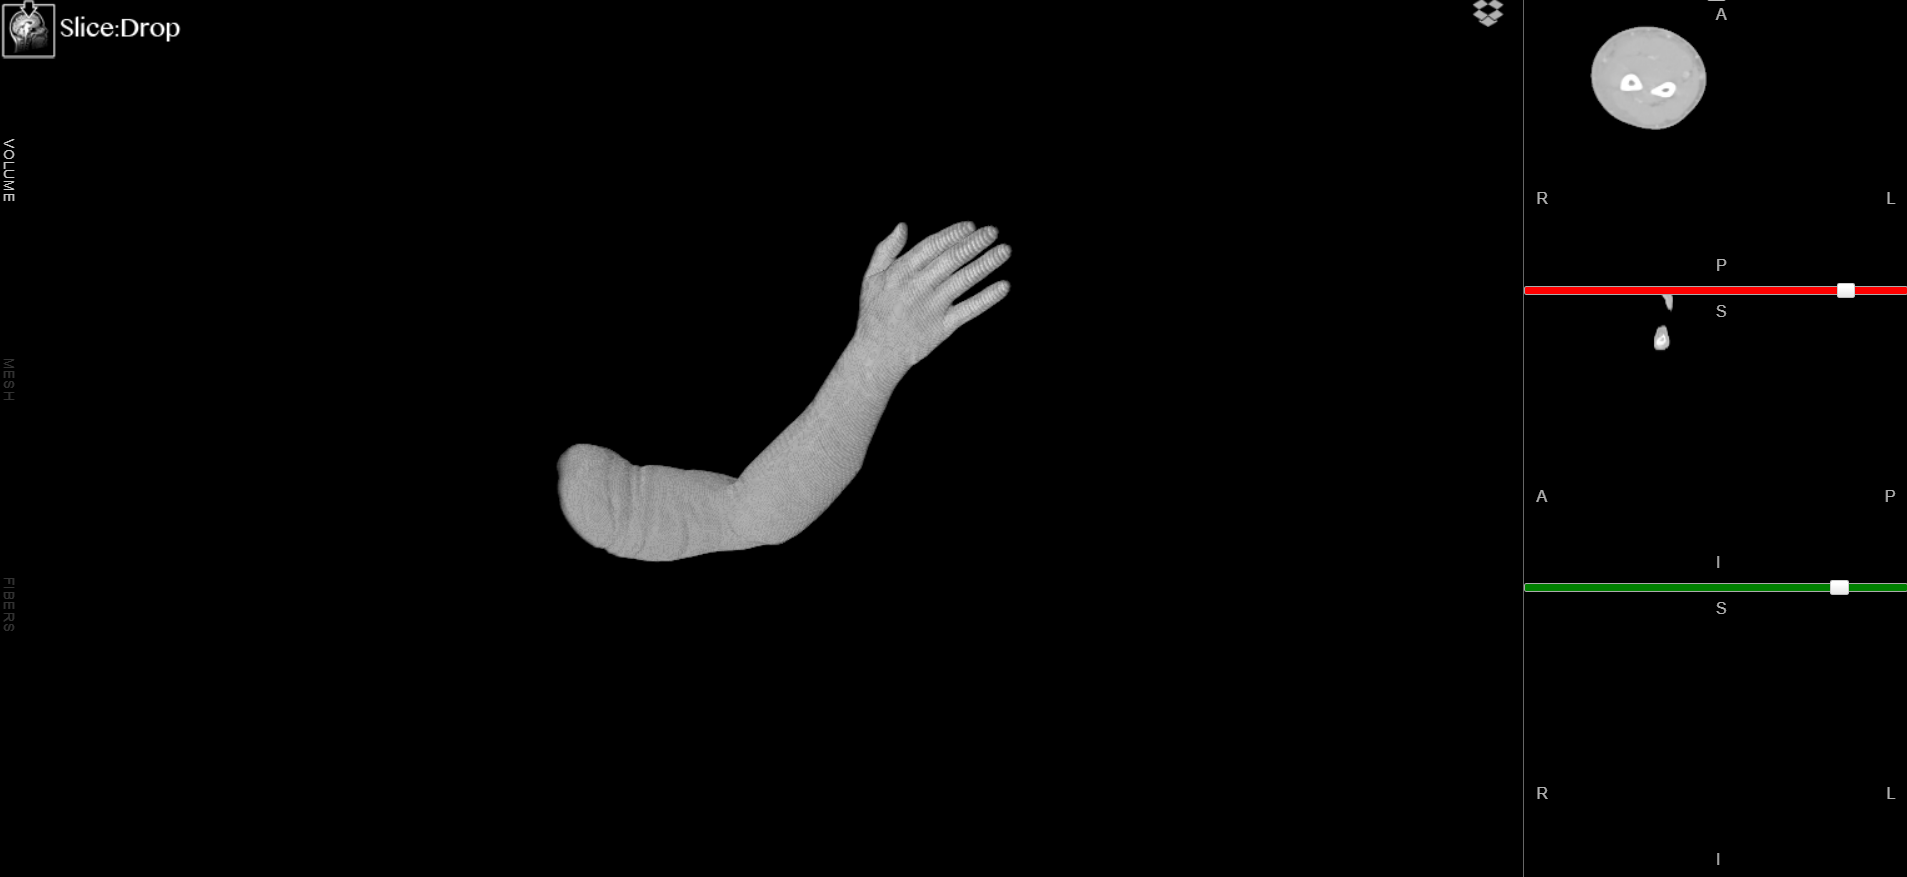

**Task 2**: Load the data using pydicom as a 3D volume and then reslice it! [35 Points]

In [10]:
# TODO: Please upload ct.zip using the file panel on the left.
# Then use the following snippet to extract the data.

In [11]:
import zipfile
with zipfile.ZipFile('ct.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [30]:
# 1) Now loop through all the DICOM files and store them in a 3D numpy array.
# Hint: You can either store them in a list first or read the dimensions of a
# single image slice to properly create the 3D numpy array.
# Hint 2: os.listdir(DIR) gives a list of filenames in a directory.
# Hint 2b: This list is not sorted - make sure you sort it.
# Hint 3: The dcmread function loads a single DICOM file.
# Hint 4: You can then use .pixel_array to access the image data.
from pydicom import dcmread
import os
import numpy as np

In [31]:
from pydicom import dcmread

In [32]:
# TODO: YOUR CODE FOR LOADING THE VOLUME AS A 3D NUMPY ARRAY
file_names = sorted(os.listdir("ct"))
files=[]
for fname in file_names:
  files.append(dcmread("ct/"+fname))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1
# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# creating a 3d volume from the slices
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

#img3d is the 3D volume made out of reading all slices
print(img3d.shape)

(454, 512, 220)


In [ ]:
# 2) Now create and show axial, sagittal, and coronal slices from the 3D volume.
# Hint: Please use imshow(XX, cmap='gray') to show the image.

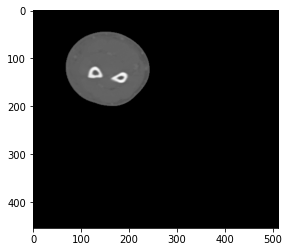

In [33]:
# TODO: YOUR CODE FOR AXIAL
plt.imshow(img3d[:, :, img_shape[2]//2], cmap='gray')

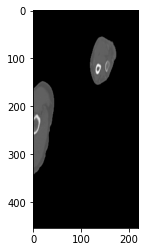

In [34]:
# TODO: YOUR CODE FOR SAGITTAL
plt.imshow(img3d[:,img_shape[1]//2 , :], cmap='gray')

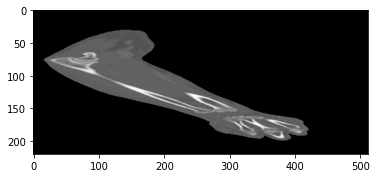

In [35]:
# TODO: YOUR CODE FOR CORONAL
plt.imshow(img3d[118, :, :].T, cmap='gray')

**Task 3**: Use the Window/Level-technique to visualize the data! [45 Points]

In [ ]:
# We will now enhance the visualization from above by performing 
# Window/Level adjustment.
# Here is one way of doing that:
#   vmin = level - window/2
#   vmax = level + window/2
#   plt.imshow(hu_pixels + rescale, cmap='gray', vmin=vmin, vmax=vmax)
#   plt.show()

In [ ]:
# 1) Please load the Window/Level values from the DICOM file,
# print these values, and then visualize one slice with window/level adjustment.
# Hint: The DICOM header has the following tags.
#   (0028, 1050) Window Center 
#   (0028, 1051) Window Width
# Hint 2: You can use slice[key].value to access DICOM tag values.
# Hint 3: (0028, 1052) Rescale Intercept might be important.

In [36]:
# TODO: YOUR CODE
img = img3d[:, :, 0]
slice = slices[0]
print(slice[0x0028,0x1050].keyword, "\t\t: ", slice[0x0028,0x1050].value)
print(slice[0x0028,0x1051].keyword, "\t\t: ", slice[0x0028,0x1051].value)
print(slice[0x0028,0x1052].keyword, "\t: ", slice[0x0028,0x1052].value)

WindowCenter 		:  30
WindowWidth 		:  410
RescaleIntercept 	:  -1024


In [ ]:
# 2) Play around with different Window/Level values that enhance
# the visualization.

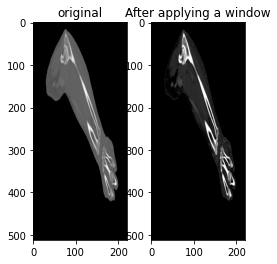

In [37]:
# TODO: YOUR CODE
def convert_to_hu(slice, px):
    # convert slice into hounsfield units
    intercept = slice.RescaleIntercept
    slope = slice.RescaleSlope
    hu_image = px * slope + intercept
    return hu_image

def apply_window(img, window_center, window_width):
    # based on the center and width this function
    # will apply a window
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed = img.copy()
    windowed[windowed < img_min] = img_min
    windowed[windowed > img_max] = img_max
    return windowed

# process the whole 3d volume
ct_windowed = np.zeros(img3d.shape)
for i in range(220):
  hu = convert_to_hu(slices[i], img3d[:,:,i])
  windowed = apply_window(hu, 400, 1000)
  ct_windowed[:, :, i] = windowed

# displaying a random slice
plt.subplot("131")
plt.title("original")
plt.imshow(img3d[118, :, :], cmap='gray')
plt.subplot("132")
plt.title("After applying a window")
plt.imshow(ct_windowed[118,:,:], cmap='gray')

In [ ]:
# Which values make sense and why?

In [ ]:
# TODO: YOUR ANSWER

There are various answers that makes sense.

**Bonus**: Create segmentations (label maps) for the volume using thresholding HU! [33 Points]

In [ ]:
# Similar to Window/Level adjustment for visualization, we can threshold
# the volume to highlight the following components using the Hounsfield Units:
# 1) Fat
# 2) Soft Tissue
# 3) Bones
#
# Please create 3 segmentation masks for these structures.
# Then, please visualize each 3 slices per structure to showcase the segmentation.
# Hint: As a reminder, the following code allows thresholding of a numpy array.
#   new_mask = imagevolume.copy()
#   new_mask[new_mask < XXX] = 0
# Hint2: You might need to cast new_mask to int16 not uint16.

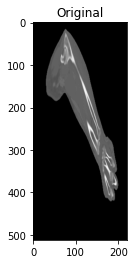

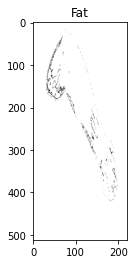

In [39]:
# TODO: YOUR CODE TO SEGMENT FAT
def segment(img, window_center, window_width):
    # calculate threshold values
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    mask = img.copy()
    # creating mask
    mask[mask < img_min] = 0
    mask[mask > img_max] = 0
    mask[mask != 0] = 1
    mask = mask.astype(int)
    segmented_image = mask * img
    return segmented_image, mask

ct_seg = np.zeros(img3d.shape)
ct_mask = np.zeros(img3d.shape)
#fat
for i in range(220):
  hu = convert_to_hu(slices[i], img3d[:,:,i])
  seg, mask = segment(hu, -50, 40)
  ct_seg[:, :, i] = seg
  ct_mask[:, :, i] = mask

plt.imshow(img3d[118,:,:], cmap='gray')
plt.title('Original')
plt.show()

plt.imshow(ct_seg[118,:,:], cmap='gray')
plt.title('Fat')
plt.show()

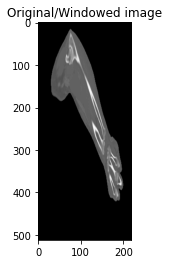

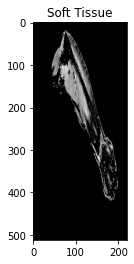

In [40]:
# TODO: YOUR CODE TO SEGMENT SOFT TISSUE
for i in range(220):
  hu = convert_to_hu(slices[i], img3d[:,:,i])
  seg, mask = segment(hu, 50, 100)
  ct_seg[:, :, i] = seg
  ct_mask[:, :, i] = mask

plt.imshow(img3d[118,:,:], cmap='gray')
plt.title('Original/Windowed image')
plt.show()

plt.imshow(ct_seg[118,:,:], cmap='gray')
plt.title('Soft Tissue')
plt.show()

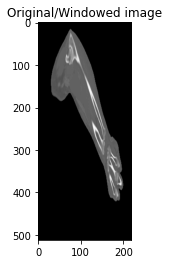

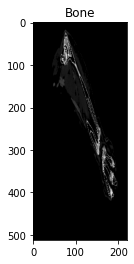

In [41]:
# TODO: YOUR CODE TO SEGMENT BONES
for i in range(220):
  hu = convert_to_hu(slices[i], img3d[:,:,i])
  seg, mask = segment(hu, 400, 700)
  ct_seg[:, :, i] = seg
  ct_mask[:, :, i] = mask

plt.imshow(img3d[118,:,:], cmap='gray')
plt.title('Original/Windowed image')
plt.show()

plt.imshow(ct_seg[118,:,:], cmap='gray')
plt.title('Bone')
plt.show()

In [ ]:
# Are the segmentations good?

In [ ]:
# TODO: YOUR ANSWER

The segmentation looks good, but it is not good enough. The values can be used in much better way than what we got

Collab. with Anudeep reddy v

In [ ]:
#
# Thank you and Great job!!
#
#                _.---._
#              .'       `.
#              :)       (:
#              \ (@) (@) /
#               \   A   /
#                )     (
#                \"""""/
#                 `._.'
#                  .=.
#          .---._.-.=.-._.---.
#         / ':-(_.-: :-._)-:` \
#        / /' (__.-: :-.__) `\ \
#       / /  (___.-` '-.___)  \ \
#      / /   (___.-'^`-.___)   \ \
#     / /    (___.-'=`-.___)    \ \
#    / /     (____.'=`.____)     \ \
#   / /       (___.'=`.___)       \ \
#  (_.;       `---'.=.`---'       ;._)
#  ;||        __  _.=._  __        ||;
#  ;||       (  `.-.=.-.'  )       ||;
#  ;||       \    `.=.'    /       ||;
#  ;||        \    .=.    /        ||;
#  ;||       .-`.`-._.-'.'-.       ||;
# .:::\      ( ,): O O :(, )      /:::.
# |||| `     / /'`--'--'`\ \     ' ||||
# ''''      / /           \ \      ''''
#          / /             \ \
#         / /               \ \
#        / /                 \ \
#       / /                   \ \
#      / /                     \ \
#     /.'                       `.\
#    (_)'                       `(_)
#     \\.                       .//
#      \\.                     .//
#       \\.                   .//
#        \\.                 .//
#         \\.               .//
#          \\.             .//
#     jgs   \\.           .//
#           ///)         (\\\
#         ,///'           `\\\,
#        ///'               `\\\
#       ""'                   '""